In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_5d_path = os.path.join(cwd, '..', 'models_5d_gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (Evolution,
                   prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           xtry_langevin_sampling_plot_2d,
                           epoch_visualization)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          xtry_langevin_sampling,
                          gan_energy,
                          Gaussian_mixture,
                          IndependentNormal,
                          DotDict)
from params_5d_gaussians_jensen import (num_samples_in_cluster,
                                        dim,
                                        num_gaussian_per_dim,
                                        coord_limits,
                                        sigma,
                                        random_seed,
                                        n_dim,
                                        n_layers_d,
                                        n_layers_g,
                                        n_hid_d,
                                        n_hid_g,
                                        n_out,
                                        device)

# 5D Gaussians, true target

In [5]:
X_train = prepare_gaussians(num_samples_in_cluster = num_samples_in_cluster, 
                            dim = dim, 
                            num_gaussian_per_dim = num_gaussian_per_dim, 
                            coord_limits = coord_limits, 
                            sigma = sigma,
                            random_seed = random_seed)

In [13]:
target_args = DotDict()
target_args.device = device
target_args.num_gauss = num_gaussian_per_dim ** dim


###create points
coords_per_dim = np.linspace(-coord_limits, 
                             coord_limits, 
                             num = num_gaussian_per_dim)
copy_coords = list(np.tile(coords_per_dim, (dim, 1)))
centers = np.array(np.meshgrid(*copy_coords), dtype = np.float64).T.reshape(-1, dim)

coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor(centers[i]).to(device) for i in range(centers.shape[0])]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(dim, dtype = torch.float64).to(device)]*target_args.num_gauss
target_args.dim = dim
true_target = Gaussian_mixture(target_args).log_prob

loc = torch.zeros(dim).to(device)
scale = torch.ones(dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal_5d = IndependentNormal(proposal_args)

In [14]:
grad_step = 1e-4
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
batchsize = batch_size_sample // n_batches
X_langevin, zs = langevin_sampling(true_target, 
                                   proposal_5d, 
                                   n_steps, 
                                   grad_step, 
                                   eps_scale, 
                                   batch_size_sample, 
                                   batchsize)

100%|██████████| 10/10 [01:37<00:00,  9.75s/it]


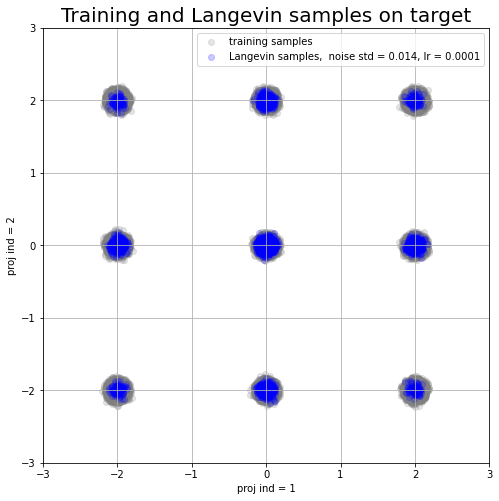

In [20]:
proj_1 = 0
proj_2 = 1
title_langevin = "Training and Langevin samples on target"
label_langevin = f'Langevin samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_langevin, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_langevin,
                          fake_label = label_langevin)

In [17]:
grad_step = 1e-4
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
acceptance_rule = 'Hastings'
batchsize = batch_size_sample // n_batches
X_mala_hastings, zs = mala_sampling(true_target, 
                                    proposal_5d, 
                                    n_steps, 
                                    grad_step, 
                                    eps_scale, 
                                    batch_size_sample, 
                                    batchsize,
                                    acceptance_rule = acceptance_rule)

100%|██████████| 10/10 [03:09<00:00, 18.95s/it]


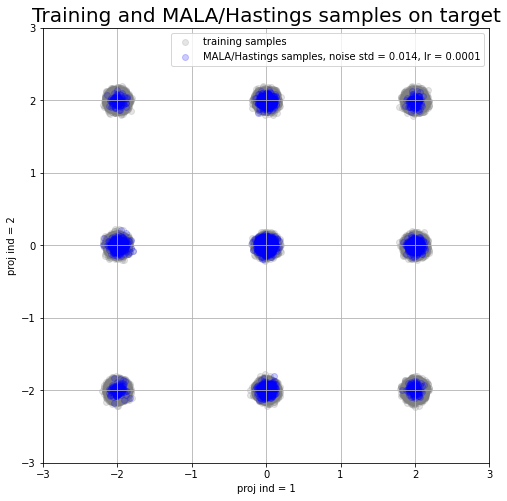

In [21]:
proj_1 = 0
proj_2 = 1
acceptance_rule = 'Hastings'
title_mala_hastings = f"Training and MALA/{acceptance_rule} samples on target"
label_mala_hastings = f'MALA/{acceptance_rule} samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_hastings, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_hastings,
                          fake_label = label_mala_hastings)

In [22]:
grad_step = 1e-4
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
acceptance_rule = 'Barker'
batchsize = batch_size_sample // n_batches
X_mala_barker, zs = mala_sampling(true_target, 
                                  proposal_5d, 
                                  n_steps, 
                                  grad_step, 
                                  eps_scale, 
                                  batch_size_sample, 
                                  batchsize,
                                  acceptance_rule = acceptance_rule)

100%|██████████| 10/10 [03:18<00:00, 19.84s/it]


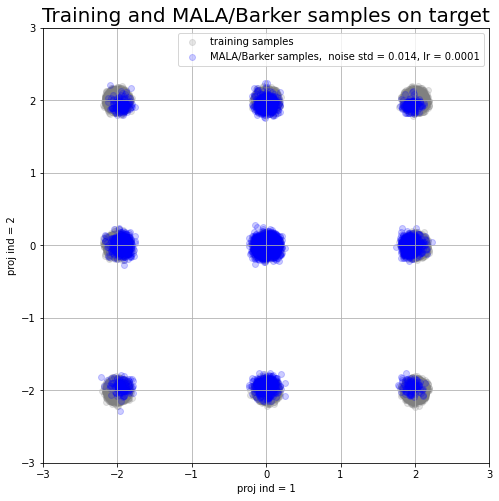

In [23]:
proj_1 = 0
proj_2 = 1
acceptance_rule = 'Barker'
title_mala_barker = f"Training and MALA/{acceptance_rule} samples on target"
label_mala_barker = f'MALA/{acceptance_rule} samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_barker, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_barker,
                          fake_label = label_mala_barker)

In [24]:
grad_step = 1e-4
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
batchsize = batch_size_sample // n_batches
N = 2
X_xtry_langevin, zs = xtry_langevin_sampling(true_target, 
                                             proposal_5d, 
                                             n_steps, 
                                             grad_step, 
                                             eps_scale, 
                                             N,
                                             batch_size_sample, 
                                             batchsize)

100%|██████████| 10/10 [03:13<00:00, 19.36s/it]


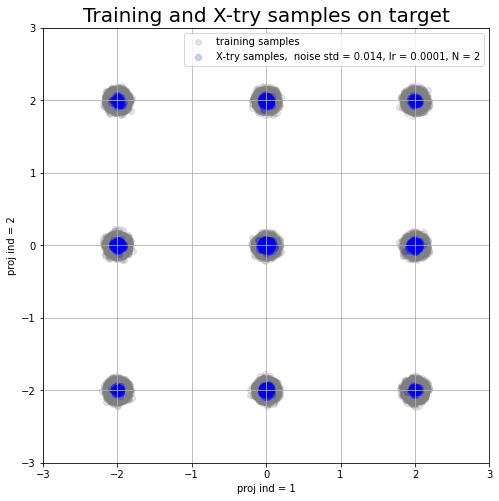

In [25]:
proj_1 = 0
proj_2 = 1
title_xtry_langevin = "Training and X-try samples on target"
label_xtry_langevin = f'X-try samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}, N = {N}'

plot_fake_data_projection(fake = X_xtry_langevin, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_xtry_langevin,
                          fake_label = label_xtry_langevin)

# 5D Gaussians, GANs

In [6]:
G_5d = Generator_fc(n_dim=n_dim, 
                    n_layers=n_layers_g,
                    n_hid=n_hid_g,
                    n_out=n_out,
                    non_linear=nn.ReLU(),
                    device=device)
D_5d = Discriminator_fc(n_in=n_dim, 
                        n_layers=n_layers_d,
                        n_hid=n_hid_d,
                        non_linear=nn.ReLU(),
                        device=device)

In [7]:
discriminator_regexp = os.path.join(models_5d_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_5d_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]
G_5d.load_state_dict(torch.load(generator_name))
D_5d.load_state_dict(torch.load(discriminator_name))

<All keys matched successfully>

In [8]:
G_5d = G_5d.to(device)
D_5d = D_5d.to(device)
for p in G_5d.parameters():  
    p.requires_grad = False
for p in D_5d.parameters():  
    p.requires_grad = False

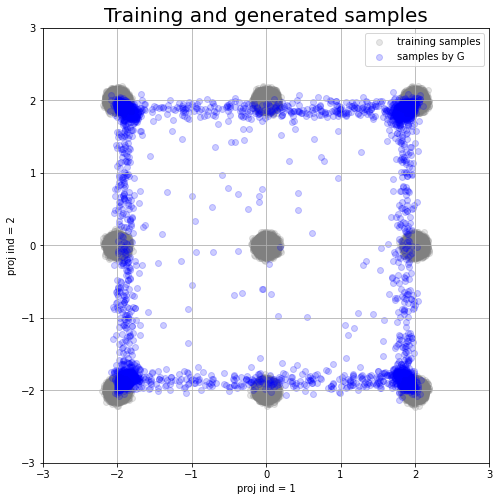

In [9]:
batch_size_sample = 5000
fake_generator = G_5d.sampling(batch_size_sample).data.cpu().numpy()
proj_1 = 0
proj_2 = 1
path_to_plot_generator = None

title_generator = "Training and generated samples"
fake_label_generator = "samples by G"

plot_fake_data_projection(fake = fake_generator, 
                          X_train = X_train,
                          path_to_save = path_to_plot_generator, 
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_generator,
                          fake_label = fake_label_generator)

100%|██████████| 5000/5000 [00:57<00:00, 86.22it/s]


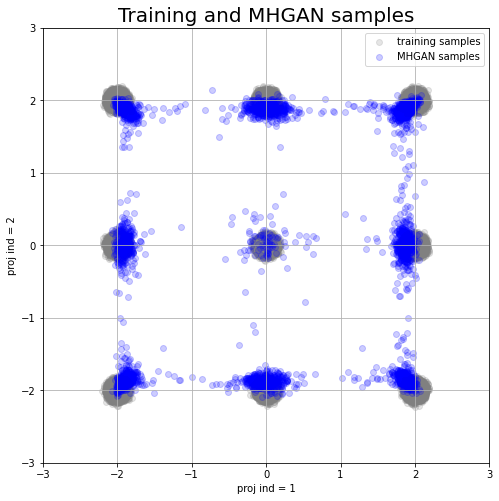

In [26]:
n_calib_pts = 6*batch_size_sample
type_calibrator = 'iso'
normalize_to_0_1 = True
X_mh = mh_sampling(X_train, 
                   G_5d, 
                   D_5d, 
                   G_5d.device, 
                   n_calib_pts, 
                   batch_size_sample=batch_size_sample,
                   normalize_to_0_1=normalize_to_0_1,
                   type_calibrator=type_calibrator)

title_mhgan = "Training and MHGAN samples"
label_mhgan = 'MHGAN samples'

plot_fake_data_projection(fake = X_mh, 
                          X_train = X_train,
                          path_to_save = path_to_plot_generator, 
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mhgan,
                          fake_label = label_mhgan)

In [27]:
n_dim = G_5d.n_dim
loc = torch.zeros(n_dim).to(G_5d.device)
scale = torch.ones(n_dim).to(G_5d.device)
normal = Normal(loc, scale)
normalize_to_0_1 = True 
log_prob = True

target_gan_5d = partial(gan_energy, 
                        generator = G_5d, 
                        discriminator = D_5d, 
                        proposal = normal,
                        normalize_to_0_1 = normalize_to_0_1,
                        log_prob = log_prob)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal_5d = IndependentNormal(proposal_args)

In [37]:
grad_step = 1e-2
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 1000
n_batches = 10
batchsize = batch_size_sample // n_batches
X_langevin_gan, zs = langevin_sampling(target_gan_5d, 
                                   proposal_5d, 
                                   n_steps, 
                                   grad_step, 
                                   eps_scale, 
                                   batch_size_sample, 
                                   batchsize)
X_langevin_gan = torch.FloatTensor(X_langevin_gan).to(proposal_5d.device)
X_langevin_gan = G_5d(X_langevin_gan).data.cpu().numpy()

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


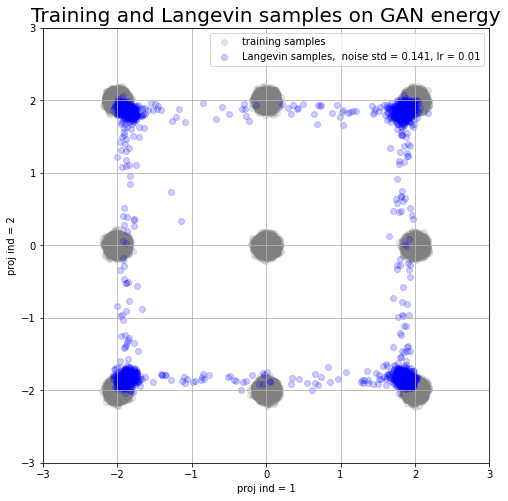

In [38]:
proj_1 = 0
proj_2 = 1
title_langevin_gan = "Training and Langevin samples on GAN energy"
label_langevin_gan = f'Langevin samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_langevin_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_langevin_gan,
                          fake_label = label_langevin_gan)

In [39]:
grad_step = 1e-2
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 1000
n_batches = 10
acceptance_rule = 'Hastings'
batchsize = batch_size_sample // n_batches
X_mala_hastings_gan, zs = mala_sampling(target_gan_5d, 
                                   proposal_5d, 
                                   n_steps, 
                                   grad_step, 
                                   eps_scale, 
                                   batch_size_sample, 
                                   batchsize,
                                   acceptance_rule = acceptance_rule)
X_mala_hastings_gan = torch.FloatTensor(X_mala_hastings_gan).to(proposal_5d.device)
X_mala_hastings_gan = G_5d(X_mala_hastings_gan).data.cpu().numpy()

100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


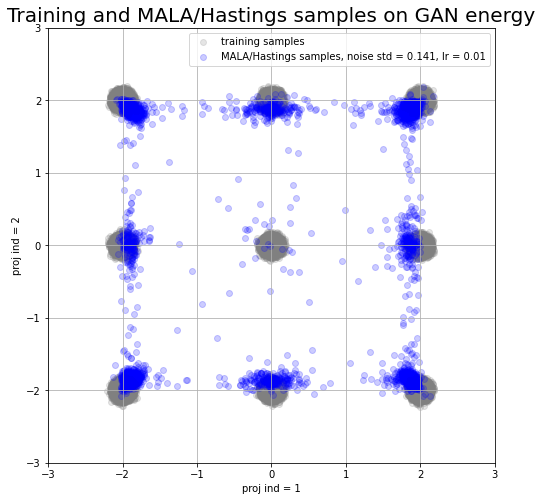

In [40]:
proj_1 = 0
proj_2 = 1
acceptance_rule = 'Hastings'
title_mala_hastings_gan = f"Training and MALA/{acceptance_rule} samples on GAN energy"
label_mala_hastings_gan = f'MALA/{acceptance_rule} samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_hastings_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_hastings_gan,
                          fake_label = label_mala_hastings_gan)

In [46]:
grad_step = 1e-2
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 1000
n_batches = 10
acceptance_rule = 'Barker'
batchsize = batch_size_sample // n_batches
X_mala_barker_gan, zs = mala_sampling(target_gan_5d, 
                                   proposal_5d, 
                                   n_steps, 
                                   grad_step, 
                                   eps_scale, 
                                   batch_size_sample, 
                                   batchsize,
                                   acceptance_rule = acceptance_rule)
X_mala_barker_gan = torch.FloatTensor(X_mala_barker_gan).to(proposal_5d.device)
X_mala_barker_gan = G_5d(X_mala_barker_gan).data.cpu().numpy()

100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


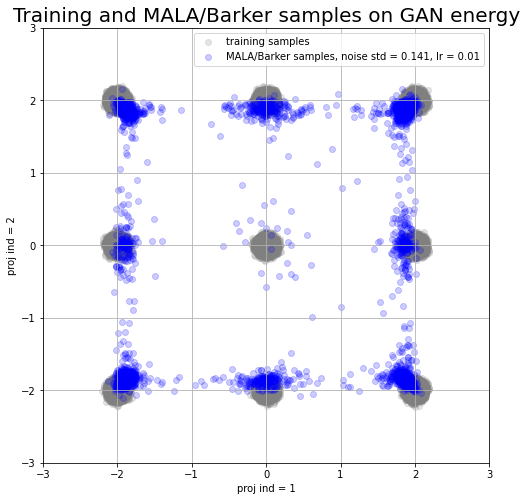

In [47]:
proj_1 = 0
proj_2 = 1
acceptance_rule = 'Barker'
title_mala_barker_gan = f"Training and MALA/{acceptance_rule} samples on GAN energy"
label_mala_barker_gan = f'MALA/{acceptance_rule} samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_barker_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_barker_gan,
                          fake_label = label_mala_barker_gan)

In [42]:
grad_step = 1e-2
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 1000
n_batches = 10
batchsize = batch_size_sample // n_batches
N = 2
X_xtry_langevin_gan, zs = xtry_langevin_sampling(target_gan_5d, 
                                             proposal_5d, 
                                             n_steps, 
                                             grad_step, 
                                             eps_scale, 
                                             N,
                                             batch_size_sample, 
                                             batchsize)

100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


In [43]:
X_xtry_langevin_gan = torch.FloatTensor(X_xtry_langevin_gan).to(proposal_5d.device)
X_xtry_langevin_gan = G_5d(X_xtry_langevin_gan).data.cpu().numpy()

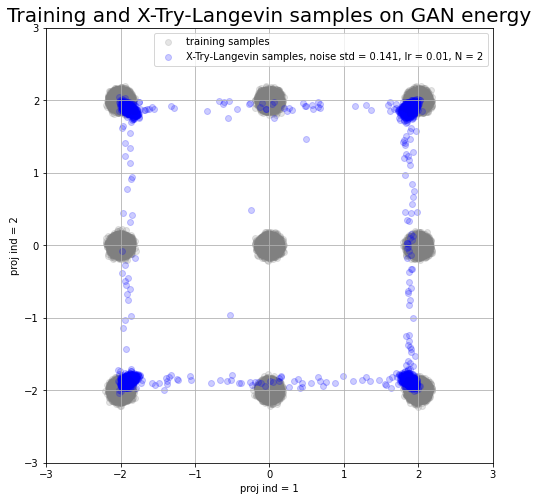

In [45]:
title_xtry_langevin_gan = "Training and X-Try-Langevin samples on GAN energy"
label_xtry_langevin_gan = f'X-Try-Langevin samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}, N = {N}'

plot_fake_data_projection(fake = X_xtry_langevin_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_xtry_langevin_gan,
                          fake_label = label_xtry_langevin_gan)